In [1]:
# Nestor Cabello, Elham Naghizade, Jianzhong Qi, Lars Kulik

# Cabello N, Naghizade E, Qi J, Kulik L (2021) Fast, Accurate and Interpretable Time Series Classification 
# Through Randomization.

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from rSTSF_functions import *

In [2]:
dset_names = ["ItalyPowerDemand"]
# dset_names = ["ItalyPowerDemand","LargeKitchenAppliances","SonyAIBORobotSurface2","ECG200"]

agg_fns = [np.mean, np.std, np.polyfit, np.median, np.min, np.max, iqr, np.percentile, np.quantile]
# np.percentile and np.quantile are just used as identifiers for 
# count mean-crossings and count of values above mean statistics. See function getIntervalFeature(...)

nruns = 1
repr_types = [1,2,3,4] # 1: Raw series, 2: Periodogram, 3: First-order Difference, 4: Autoregressive
d = 50 # Number of sets of candidate discriminatory interval features to compute
r = 500 # Number of trees

accuracies = np.zeros((len(dset_names),nruns))
training_times = []
testing_times = []

cont_dsets = 0
for dset_name in dset_names:
    print("Dataset: ", dset_name)

    X_train_ori, y_train_ori, X_test, y_test = getTrainTestSets(dset_name)
    
    inner_training_time = []
    inner_testing_time = []
    
    for nrun in range(nruns):
        print('run ',str(nrun+1))
        timeA = time.perf_counter()
        
        #For cases of unbalanced datasets --> oversampling
        X_train, per_X_train, diff_X_train, ar_X_train, y_train = dataAugmented(X_train_ori,y_train_ori)

        
        # For the extraction of candidate interval features we use the FisherScore feature ranking metric. 
        # For such metric, all features must z-normalized.
        X_train_norm = zscore(X_train, axis=0, ddof=1)
        X_train_norm[np.isnan(X_train_norm)] = 0 # In case of Nan values set them to zero
        per_X_train_norm = getPeriodogramRepr(X_train_norm)
        diff_X_train_norm = np.diff(X_train_norm)

        ar_X_train_norm = ar_coefs(X_train_norm)
        ar_X_train_norm[np.isnan(ar_X_train_norm)] = 0 # In case of Nan values set them to zero

        all_X_train_T = np.zeros((X_train.shape[0],1))
        all_candidate_agg_feats = []


        for t in range(d): # Compute d sets of candidate discriminatory interval features 
            candidate_agg_feats,X_train_T = getAllCandidateAggFeats(X_train, y_train, agg_fns, repr_types, 
                                                             per_X_train, diff_X_train, ar_X_train,
                                                             X_train_norm, per_X_train_norm, diff_X_train_norm,
                                                             ar_X_train_norm)
            
            # Merge each computed interval-based representation
            all_X_train_T = np.hstack((all_X_train_T,X_train_T)) 
            all_candidate_agg_feats.extend(candidate_agg_feats)
        
        all_X_train_T = all_X_train_T[:,1:]

        clf = ExtraTreesClassifier(n_estimators=r,criterion='entropy',class_weight='balanced',max_features='sqrt')
        clf.fit(all_X_train_T, y_train) # Train the ensemble of ET classifiers

        current_training_time = time.perf_counter()-timeA
        inner_training_time.append(current_training_time)
        print("training time: ", current_training_time)

        timeA = time.perf_counter()
        
        per_X_test = getPeriodogramRepr(X_test)
        diff_X_test = np.diff(X_test)
        ar_X_test = ar_coefs(X_test)
        ar_X_test[np.isnan(ar_X_test)] = 0

        # The testing set has to be transformed into an interval-based representation
        # use only the relevant interval as according to the training process (i.e., tree nodes)
        relevant_caf_idx = []
        relevant_caf_idx_per_tree = []
        for dt_tree in clf.estimators_:
            caf_idx_to_train = dt_tree.tree_.feature
            relevant_caf_idx_per_tree.append(np.unique(caf_idx_to_train[caf_idx_to_train>=0])) #save the most discriminatory interval features on each tree
            relevant_caf_idx.extend(caf_idx_to_train[caf_idx_to_train>=0])
        relevant_caf_idx = np.unique(relevant_caf_idx)
        
        X_test_T = getIntervalBasedTransform(X_test, per_X_test, diff_X_test, ar_X_test, all_candidate_agg_feats, relevant_caf_idx)
        y_pred = clf.predict(X_test_T)

        current_testing_time = time.perf_counter()-timeA
        inner_testing_time.append(current_testing_time)
        print("testing time: ", current_testing_time)

        accu = np.sum(y_pred==y_test)/len(y_test)
        print('accuracy: ', accu)
        accuracies[cont_dsets,nrun] = accu

    avg_accuracy_this_dataset = np.mean(accuracies[cont_dsets,:])
    print('avg accuracy for ' + str(nruns) + ' runs: ' , avg_accuracy_this_dataset)
    
    training_times.append(np.mean(inner_training_time))
    testing_times.append(np.mean(inner_testing_time))

    cont_dsets+=1
    print("\n")

Dataset:  ItalyPowerDemand
run  1
training time:  128.1734217000012
testing time:  0.5628513999981806
accuracy:  0.9737609329446064
avg accuracy for 1 runs:  0.9737609329446064




In [3]:
# Get the information (i.e., starting and ending indices, aggregation function and time series representation) from each relevant interval feature
trees_start_idx,trees_end_idx,trees_agg_fns,trees_repr_types = get_lst_start_ending_indices(relevant_caf_idx_per_tree, all_candidate_agg_feats)

In [4]:
# Get the matrix of predictions, of size number of testing instances X number of trees.
# For a given testing instance, each tree provides its predicted class label

# To extract the matrix of predictions we are re-running the testing of the instances. 
# due to y_pred = clf.predict(X_test_T) already uses the functions predict_proba (line 10 below)
# To the best of our knowledge scikit-learn does not provide the matrix of predicitions. However, this could
# be easily adapted into this library to avoid unnecessary computations at testing time.
all_trees_predict = []
for tree in clf.estimators_:
    proba = tree.predict_proba(X_test_T)
    cur_prediction = clf.classes_.take(np.argmax(proba, axis=1), axis=0)
    all_trees_predict.append(cur_prediction)
all_trees_predict = np.array(all_trees_predict)
all_trees_predict = all_trees_predict.transpose()

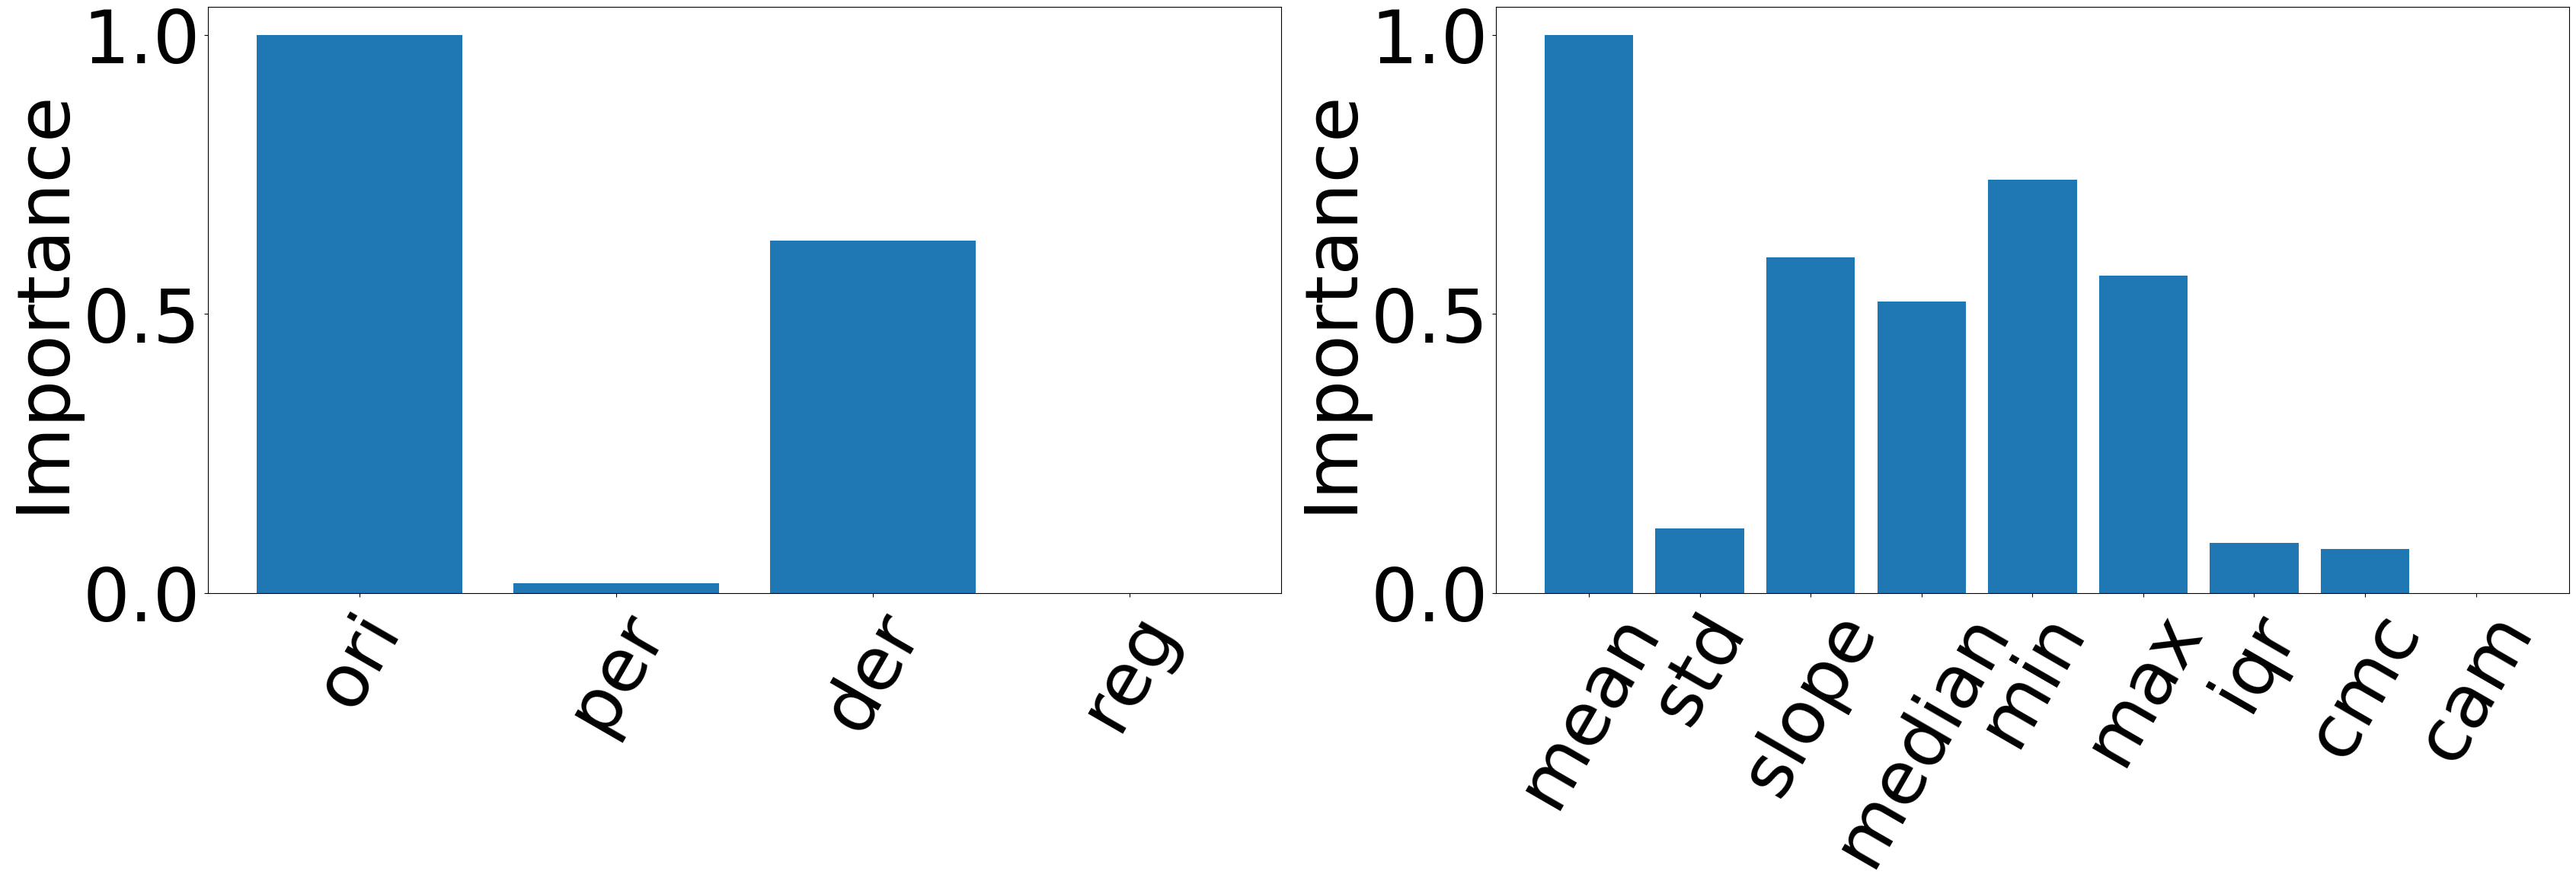

In [5]:
fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(40,10))

#Compute the importance of each time series representation
repr_importances = getReprImportances(clf, all_candidate_agg_feats)
normalized_repr_importances = (repr_importances-np.min(repr_importances))/(np.max(repr_importances)-np.min(repr_importances))
ax1.bar([1,2,3,4], normalized_repr_importances, tick_label=["ori","per","der","reg"])
ax1.tick_params(axis='x', labelsize=70, labelrotation=60)


most_important_representation = 1 #original (raw) time series representation

#Compute the importance of each aggregation function 
#(according to the relevant features found with the most important TS representation)
stats_importances = getStatsImportances(clf, all_candidate_agg_feats, most_important_representation)
normalized_stats_importances = (stats_importances-np.min(stats_importances))/(np.max(stats_importances)-np.min(stats_importances))
ax2.bar([1,2,3,4,5,6,7,8,9], normalized_stats_importances, tick_label=["mean","std","slope","median","min","max","iqr","cmc","cam"])
ax2.tick_params(axis='x', labelsize=70, labelrotation=60)

for ax in fig.get_axes():
    ax.tick_params(axis='y', labelsize=70)
    ax.set_ylabel('Importance', fontsize=70)

representation type:  1
agg fn:  <function min at 0x000001E6AC4EE200>


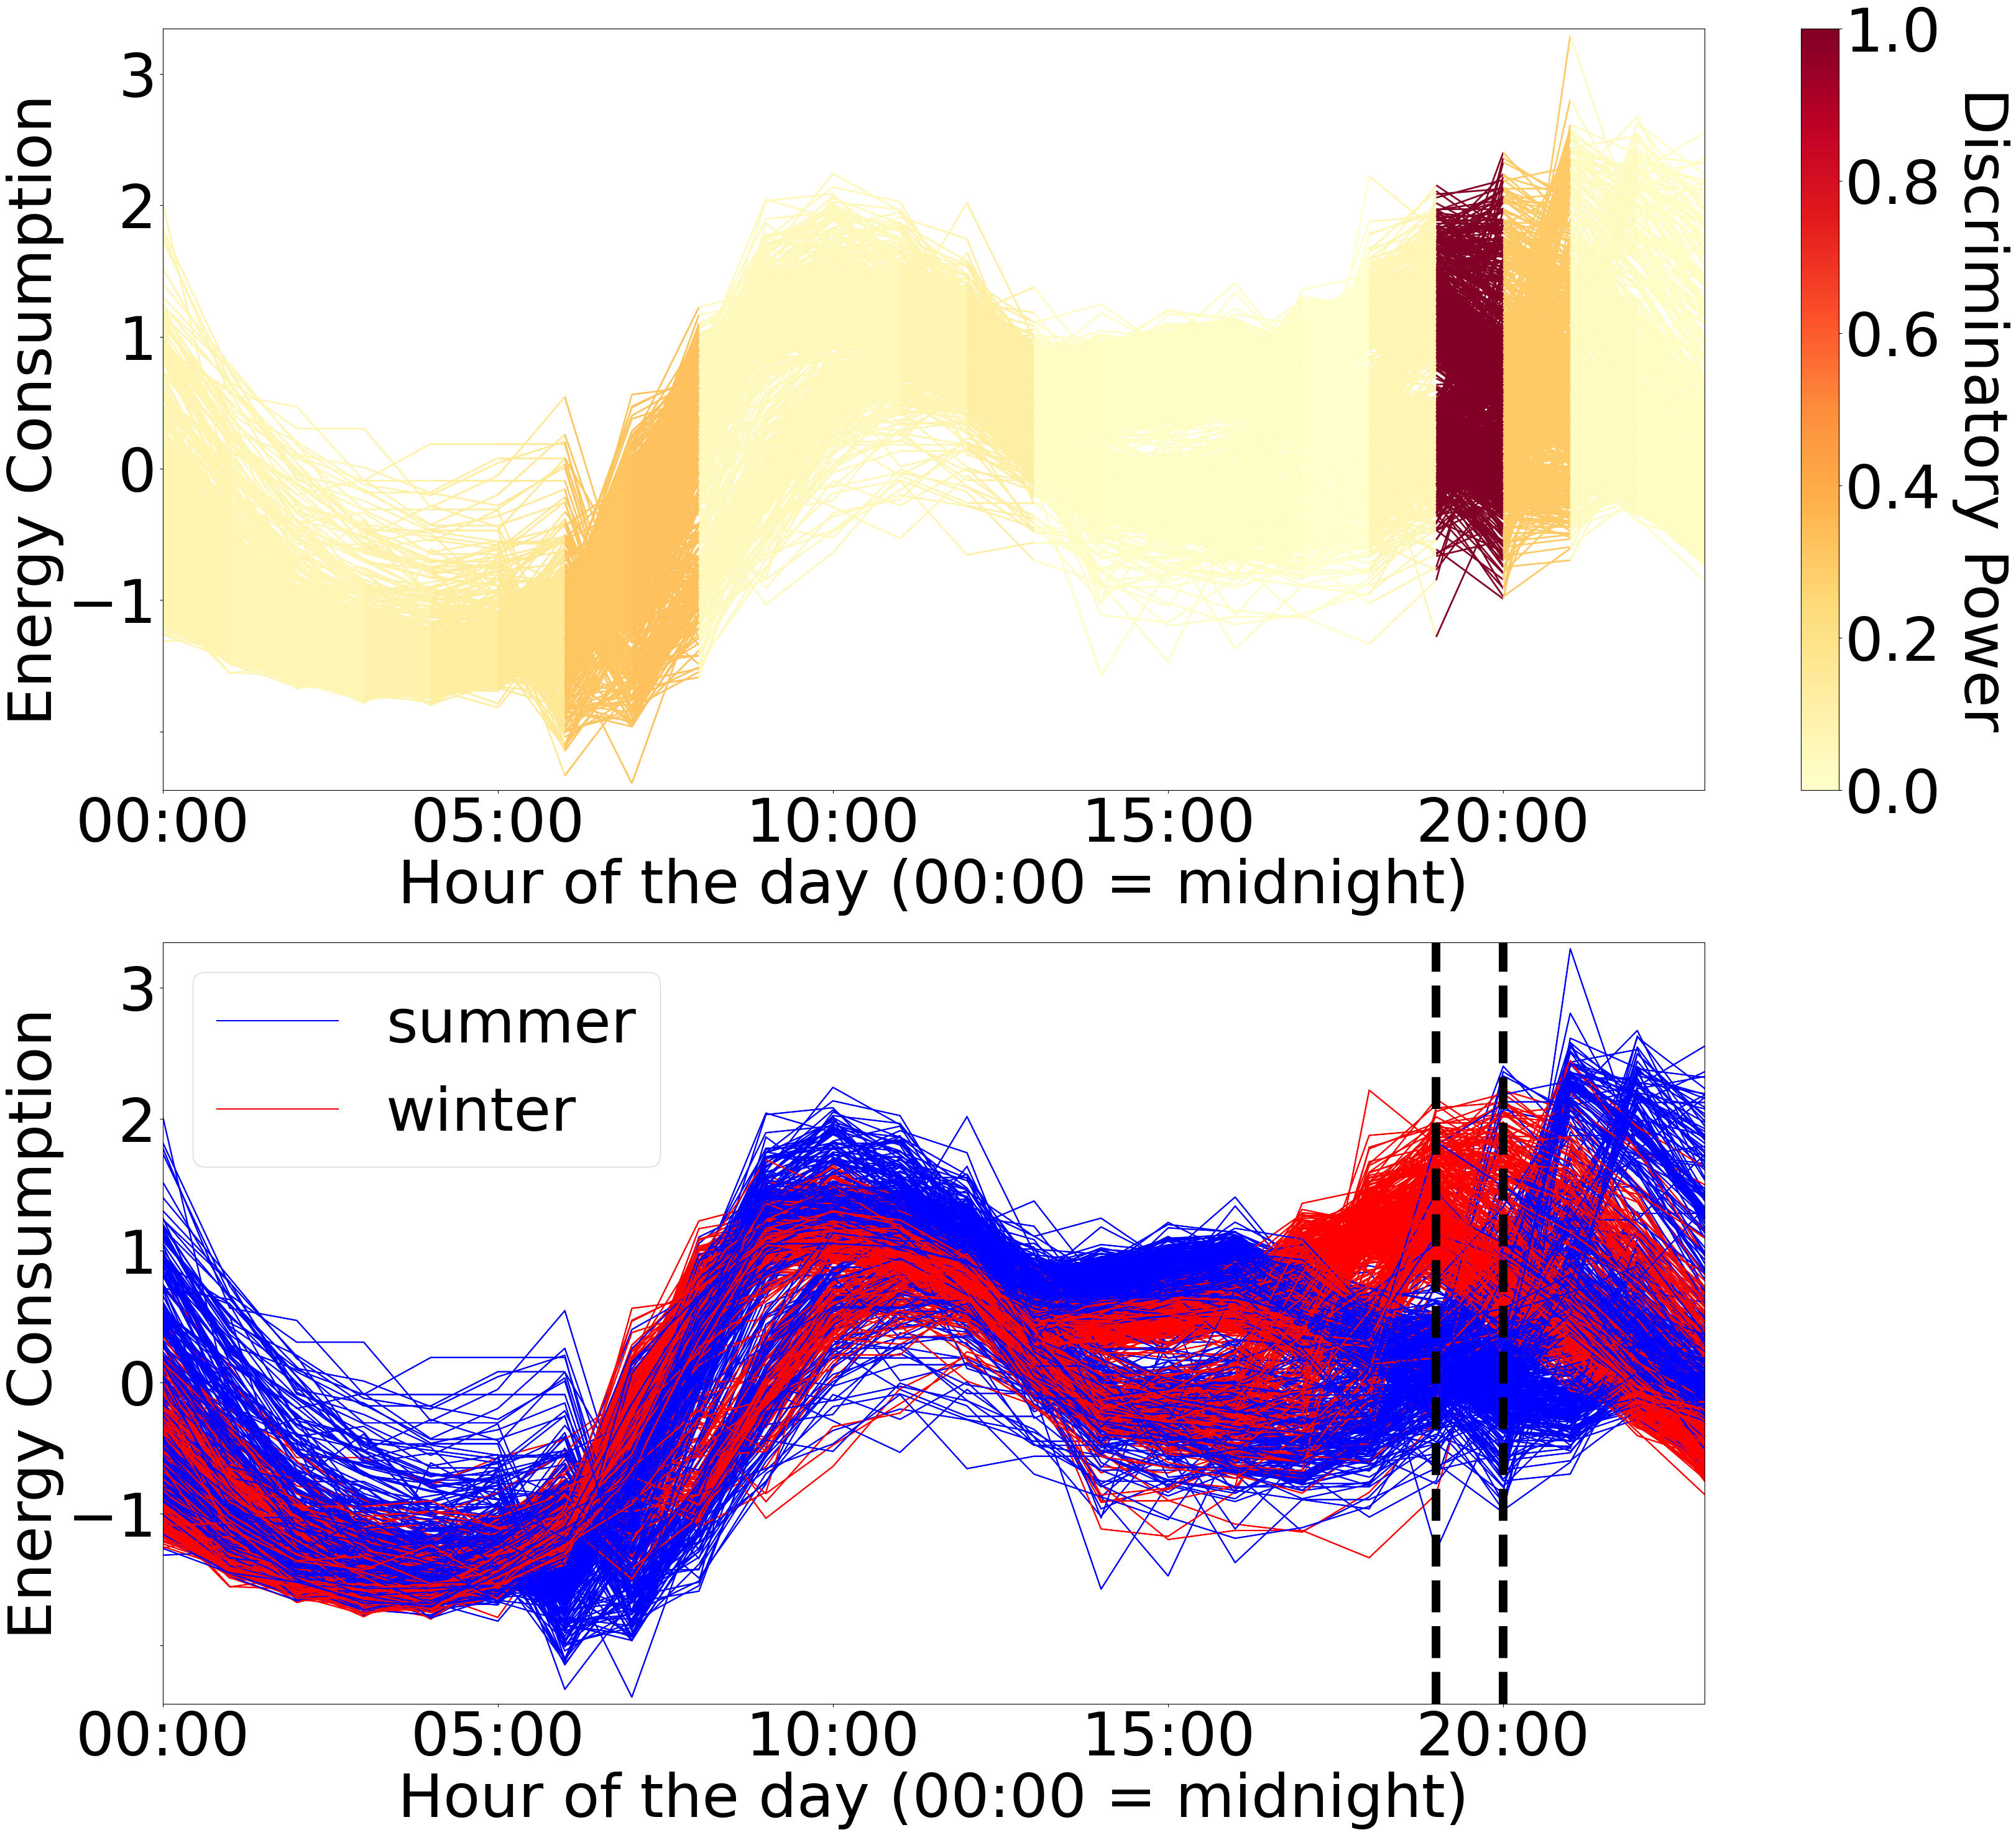

In [7]:
# Some parts of the code below are adapted for the problem of ItalyPowerDemand dataset


to_use_start_idx,to_use_end_idx,to_use_agg_fns,to_use_repr_types = trees_start_idx, trees_end_idx, trees_agg_fns, trees_repr_types

nfeats = X_test.shape[1]

per_X_test = getPeriodogramRepr(X_test)
diff_X_test = np.diff(X_test)
ar_X_test = ar_coefs(X_test)

# for this example we use the min aggregation function
agg_fns = [np.min]#np.mean, np.std, np.polyfit, np.median, np.min, np.max, iqr, np.percentile, np.quantile]

for agg_fn in agg_fns:
    for repr_type in [1]:#[1,2,3,4]: #for this example we use the origianl representation
        print('representation type: ', repr_type)
        print('agg fn: ', agg_fn)
        already_used_start_end_idx = []

        for t in range(r):
            all_start_idx_to_use,all_end_idx_to_use = get_all_start_end_idx_per_tree(t, agg_fn, repr_type, to_use_start_idx, to_use_end_idx, to_use_agg_fns, to_use_repr_types)
            if len(all_start_idx_to_use)>0:
                for i in range(len(all_start_idx_to_use)):
                    already_used_start_end_idx.append((all_start_idx_to_use[i],all_end_idx_to_use[i]))


        ######### plot discriminatory regions ###########
        
        if repr_type == 1:
            X_test_to_use = X_test
        elif repr_type == 2:
            X_test_to_use = per_X_test
        elif repr_type == 3:
            X_test_to_use = diff_X_test
        elif repr_type == 4:
            X_test_to_use = ar_X_test
        else:
            print("ERROR")

        
        intensity_map = candDiscrIntFeats_per_aggfn(X_test_to_use,y_test,all_trees_predict,to_use_start_idx,to_use_end_idx,to_use_agg_fns,to_use_repr_types,repr_type,agg_fn)
      
        max_value = np.max(intensity_map)
        min_value = np.min(intensity_map)
        norm_intensity_map =  (intensity_map - min_value) / (max_value-min_value)
        
        fig, ((axs),(ax2)) = plt.subplots(2, 1, figsize=(40,35))
        lstyles= ['-','--','-.',':']

        nrows =  X_test_to_use.shape[0]
        for i in range(nrows):
            x = np.arange(0,len(X_test_to_use[i]))
            y = X_test_to_use[i]
            dydx = norm_intensity_map[i]

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            norm = plt.Normalize(0,  1)
            lc = LineCollection(segments, cmap='YlOrRd', norm=norm)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(2)

            line = axs.add_collection(lc)
            if i==0:
                fig.colorbar(line, ax=axs)
            axs.tick_params(axis='x', labelsize=70)
            axs.tick_params(axis='y', labelsize=70)
            axs.set_xlim(0,len(y)-1)
            axs.set_ylim(np.min(X_test_to_use)-0.05,np.max(X_test_to_use)+0.05)
            axs.yaxis.get_major_ticks()[1].label1.set_visible(False)
            axs.set_ylabel("Energy Consumption", fontsize=70) # Adapted for ItalyPowerDemand dataset
            axs.set_xlabel("Hour of the day (00:00 = midnight)", fontsize=70) # Adapted for ItalyPowerDemand dataset
    
        cb_ax = fig.axes[2]
        cb_ax.tick_params(labelsize=70)
        cb_ax.get_yaxis().labelpad = 80
        cb_ax.set_ylabel('Discriminatory Power', rotation=270, fontsize=70)
        
        
        f_label = ["00:00", "05:00", "10:00", "15:00", "20:00"] # Adapted for ItalyPowerDemand dataset
        axs.set_xticklabels(f_label)

        X_test_to_use = X_test.copy()

        nrows,ncols = X_test_to_use.shape
        styles = ['r','b','b','k','c','m','y']
        
        
        ########.   Adapted for ItalyPowerDemand dataset  ##########
        already_label_0 = 0
        already_label_1 = 0
        for i in range(nrows):
            label = y_test[i]-1
            if label==0 and already_label_0==0:
                ax2.plot(X_test_to_use[i,:], styles[label], label="winter")
                already_label_0 = 1
            else:
                ax2.plot(X_test_to_use[i,:], styles[label])
                
            if label==1 and already_label_1==0:
                ax2.plot(X_test_to_use[i,:], styles[label], label="summer")
                already_label_1 = 1
            else:
                ax2.plot(X_test_to_use[i,:], styles[label])
        #############################################################
                

        ax2.tick_params(axis='x', labelsize=70)
        ax2.tick_params(axis='y', labelsize=70)
        ax2.set_xlim(0,ncols-1)
        ax2.set_ylim(np.min(X_test_to_use)-0.05,np.max(X_test_to_use)+0.05)
        ax2.yaxis.get_major_ticks()[1].label1.set_visible(False)
        
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        leg = ax2.legend(loc='best', prop={'size': 70})
        
        # Code changes due to deprecated ->
        
        # Adjusting the legend handles
        handles, labels = ax2.get_legend_handles_labels()

        # Update linewidth for each handle
        for handle in handles:
            handle.set_linewidth(10)
        
        # <- End changes
        
        ax2.set_xticklabels(f_label)
        ax2.set_xlabel("Hour of the day (00:00 = midnight)", fontsize=70) # Adapted for ItalyPowerDemand dataset
        ax2.set_ylabel("Energy Consumption", fontsize=70) # Adapted for ItalyPowerDemand dataset
        ax2.axvline(x=19, c='k', ls="--", linewidth=10)
        ax2.axvline(x=20, c='k', ls="--", linewidth=10)